In [17]:
import warnings
warnings.filterwarnings('ignore')

In [18]:
import tensorflow as tf
tf.reset_default_graph()

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
import pickle

training_data = pickle.load(open("data_set1.pickle", "rb"))

training_data = training_data/255.0

In [20]:
ruido_ph = tf.placeholder(tf.float32,[None, 100])

In [21]:
def gerador(ruido, reuse = None):
    with tf.variable_scope('gerador', reuse = reuse):
        #100 -> 128 -> 128 -> 784
        camada_oculta1 = tf.nn.relu(tf.layers.dense(inputs = ruido, units=1280))
        camada_oculta2 = tf.nn.relu(tf.layers.dense(inputs=camada_oculta1, units=1280))
        camada_saida = tf.layers.dense(inputs = camada_oculta2, units = 9216, activation = tf.nn.tanh)
        return camada_saida

In [22]:
imagens_reais_ph = tf.placeholder(tf.float32, [None, 9216])

In [23]:
def discriminador(X, reuse = None):
    with tf.variable_scope('discriminador', reuse = reuse):
        # 784 -> 128 -> 128 -> 1
        #camada_oculta1 = tf.nn.relu(tf.layers.dense(inputs = X, units = 1280))
        #camada_oculta2 = tf.nn.relu(tf.layers.dense(inputs = camada_oculta1, units = 1280))
        
        entrada = tf.reshape(X, [-1,96,96,1])
        
        convolucao1 = tf.layers.conv2d(inputs = entrada, filters = 32, kernel_size = [5,5], activation = tf.nn.relu,
                                       padding = 'same')
        
        pooling1 = tf.layers.max_pooling2d(inputs = convolucao1, pool_size = [2,2], strides = 2)
        
        convolucao2 = tf.layers.conv2d(inputs = pooling1, filters = 64, kernel_size=[5,5],activation=tf.nn.relu,
                                      padding = 'same')
        
        pooling2 = tf.layers.max_pooling2d(inputs=convolucao2, pool_size = [2,2], strides = 2)
        
        flattening = tf.reshape(pooling2, [-1, 24*24*64])
        
        densa = tf.layers.dense(inputs = flattening, units = 1024, activation = tf.nn.relu)
        
        dropout = tf.layers.dropout(inputs=densa, rate=0.2, training = True)
        
        logits = tf.layers.dense(inputs = dropout, units=1)
        return logits

In [24]:
logits_imagens_reais = discriminador(imagens_reais_ph)
logits_imagens_ruido = discriminador(gerador(ruido_ph), reuse = True)

erro_discriminador_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = logits_imagens_reais,
                                                                                labels = tf.ones_like(logits_imagens_reais)*(0.9)))

erro_discriminador_ruido = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = logits_imagens_ruido,
                                                                                 labels = tf.zeros_like(logits_imagens_ruido)))

erro_discriminador = erro_discriminador_real + erro_discriminador_ruido

erro_gerador = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = logits_imagens_ruido,
                                                                     labels = tf.ones_like(logits_imagens_ruido)))

In [25]:
variaveis = tf.trainable_variables()

In [26]:
variaveis_discriminador = [v for v in variaveis if 'discriminador' in v.name]

In [27]:
variaveis_gerador = [v for v in variaveis if 'gerador' in v.name]

In [28]:
treinamento_discriminador = tf.train.AdamOptimizer(learning_rate=0.001).minimize(erro_discriminador,
                                                                                var_list = variaveis_discriminador)
treinamento_gerador = tf.train.AdamOptimizer(learning_rate=0.001).minimize(erro_gerador, var_list=variaveis_gerador)

In [29]:
batch_size =  100
amostras_teste = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    #ruido_teste = np.random.uniform(-1, 1, size =(1,100))
    #amostra = sess.run(gerador(ruido_ph, reuse=True), feed_dict = {ruido_ph: ruido_teste})
    
#     batch = mnist.train.next_batch(100)
#     imagens_batch = batch[0].reshape((100, 784))
#     imagens_batch = imagens_batch*2 - 1
#     r = sess.run(discriminador(imagens_reais_ph, True), feed_dict = {imagens_reais_ph: imagens_batch})
    
    for epoca in range(5000):
        numero_batches = len(training_data) // batch_size
        for i in range(numero_batches):
            batch = training_data[batch_size*i:batch_size*i + batch_size]
            imagens_batch = batch.reshape((batch_size,9216))
            imagens_batch = imagens_batch * 2 - 1
    
            batch_ruido = np.random.uniform(-1, 1, size=(batch_size,100))
        
            _, custod = sess.run([treinamento_discriminador, erro_discriminador],
                                  feed_dict  = {imagens_reais_ph: imagens_batch, ruido_ph: batch_ruido})
            
            _, custog = sess.run([treinamento_gerador, erro_gerador], feed_dict = {ruido_ph: batch_ruido})
            
        print('época: ' + str(epoca + 1) + ' erro D: '+str(custod)+' erro G: '+str(custog))
        
        ruido_teste = np.random.uniform(-1, 1, size=(1,100))
        imagem_gerada = sess.run(gerador(ruido_ph, reuse = True), feed_dict={ruido_ph: ruido_teste})
        
        amostras_teste.append(imagem_gerada)

época: 1 erro D: 1.4086276 erro G: 0.8194201
época: 2 erro D: 0.5693381 erro G: 2.4125583
época: 3 erro D: 0.35512656 erro G: 9.247858
época: 4 erro D: 0.34205487 erro G: 12.879287
época: 5 erro D: 0.34198788 erro G: 14.263824
época: 6 erro D: 0.33405608 erro G: 14.497356
época: 7 erro D: 0.3308759 erro G: 14.35944
época: 8 erro D: 0.3307038 erro G: 13.67089
época: 9 erro D: 0.32986227 erro G: 12.812885
época: 10 erro D: 0.32996383 erro G: 11.624378
época: 11 erro D: 0.32953793 erro G: 10.261206
época: 12 erro D: 0.32945657 erro G: 8.9792
época: 13 erro D: 0.32988068 erro G: 8.039936
época: 14 erro D: 0.3290111 erro G: 7.9612317
época: 15 erro D: 0.3295503 erro G: 8.160025
época: 16 erro D: 0.32989535 erro G: 8.165537
época: 17 erro D: 0.32951996 erro G: 7.239861
época: 18 erro D: 0.32848266 erro G: 7.8752456
época: 19 erro D: 0.33028072 erro G: 6.359711
época: 20 erro D: 0.33273858 erro G: 6.0989876
época: 21 erro D: 0.3367674 erro G: 6.2403164
época: 22 erro D: 0.33151793 erro G: 8.4

KeyboardInterrupt: 

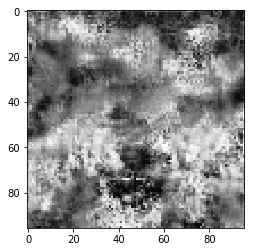

In [33]:
plt.imshow(amostras_teste[500].reshape(96,96), cmap = 'Greys')